In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [2]:
# Import the dataset
kickstarter = pd.read_excel('Kickstarter.xlsx')

In [48]:
# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df = kickstarter[kickstarter['state'].isin(['successful','failed'])]

# Convert the target variable to binary
df['state'] = df['state'].replace(['successful','failed'],[1,0])

# Convert goal to usd_goal = goal * static_usd_rate
df['usd_goal'] = df['goal'] * df['static_usd_rate']
df = df.drop(columns = 'goal')

df.head()

C:\Users\shans\AppData\Local\Temp\ipykernel_24368\263580240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['state'].replace(['successful','failed'],[1,0])
C:\Users\shans\AppData\Local\Temp\ipykernel_24368\263580240.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usd_goal'] = df['goal'] * df['static_usd_rate']


,id,name,pledged,state,disable_communication,country,currency,deadline,state_changed_at,created_at,...,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal
0,1601563193,Our future,1.00,0,False,AU,AUD,2014-10-07 12:05:39,2014-10-07 12:05:39,2014-08-01 21:22:10,...,2014,21,8,8,2014,12,6,60,60,9.289424e+07
1,880009511,Elite: Dangerous,1578316.08,1,False,GB,GBP,2013-01-04 18:00:57,2013-01-04 18:00:57,2012-10-31 11:08:38,...,2012,11,11,5,2012,18,5,60,60,2.003273e+06
4,557230947,"Bring Reading Rainbow Back for Every Child, Ev...",5408916.95,1,False,US,USD,2014-07-02 14:00:00,2014-07-02 14:00:11,2014-04-22 22:00:21,...,2014,22,5,28,2014,8,35,35,35,1.000000e+06
5,1966069095,ARKYD: A Space Telescope for Everyone,1505366.60,1,False,US,USD,2013-06-30 21:00:00,2013-06-30 21:00:34,2012-07-10 17:20:54,...,2012,17,5,29,2013,10,322,32,32,1.000000e+06
6,2083255961,A Billion Pixels...,56.00,0,False,US,USD,2014-08-04 16:39:34,2014-08-04 16:39:34,2014-05-01 16:47:47,...,2014,16,6,5,2014,16,34,60,60,1.000000e+08


# 1. Data Preprocessing

In [ ]:
# Understand the data type of each column
df.dtypes

Clustering algorithms do not work well with categorical variable (either binary or multi-class), especially K-Means.

We should consider removing all categorical variables, including: 
- datetime and those sub-columns
- category
- currency and static_usd_rate

In [ ]:
df.columns

In [49]:
# Select only numeric values
df = df[['usd_goal', 'pledged', 'backers_count', 'state',
       'usd_pledged', 'name_len', 'name_len_clean',
       'blurb_len', 'blurb_len_clean', 
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days']]

Check if there is any collinearity between variables

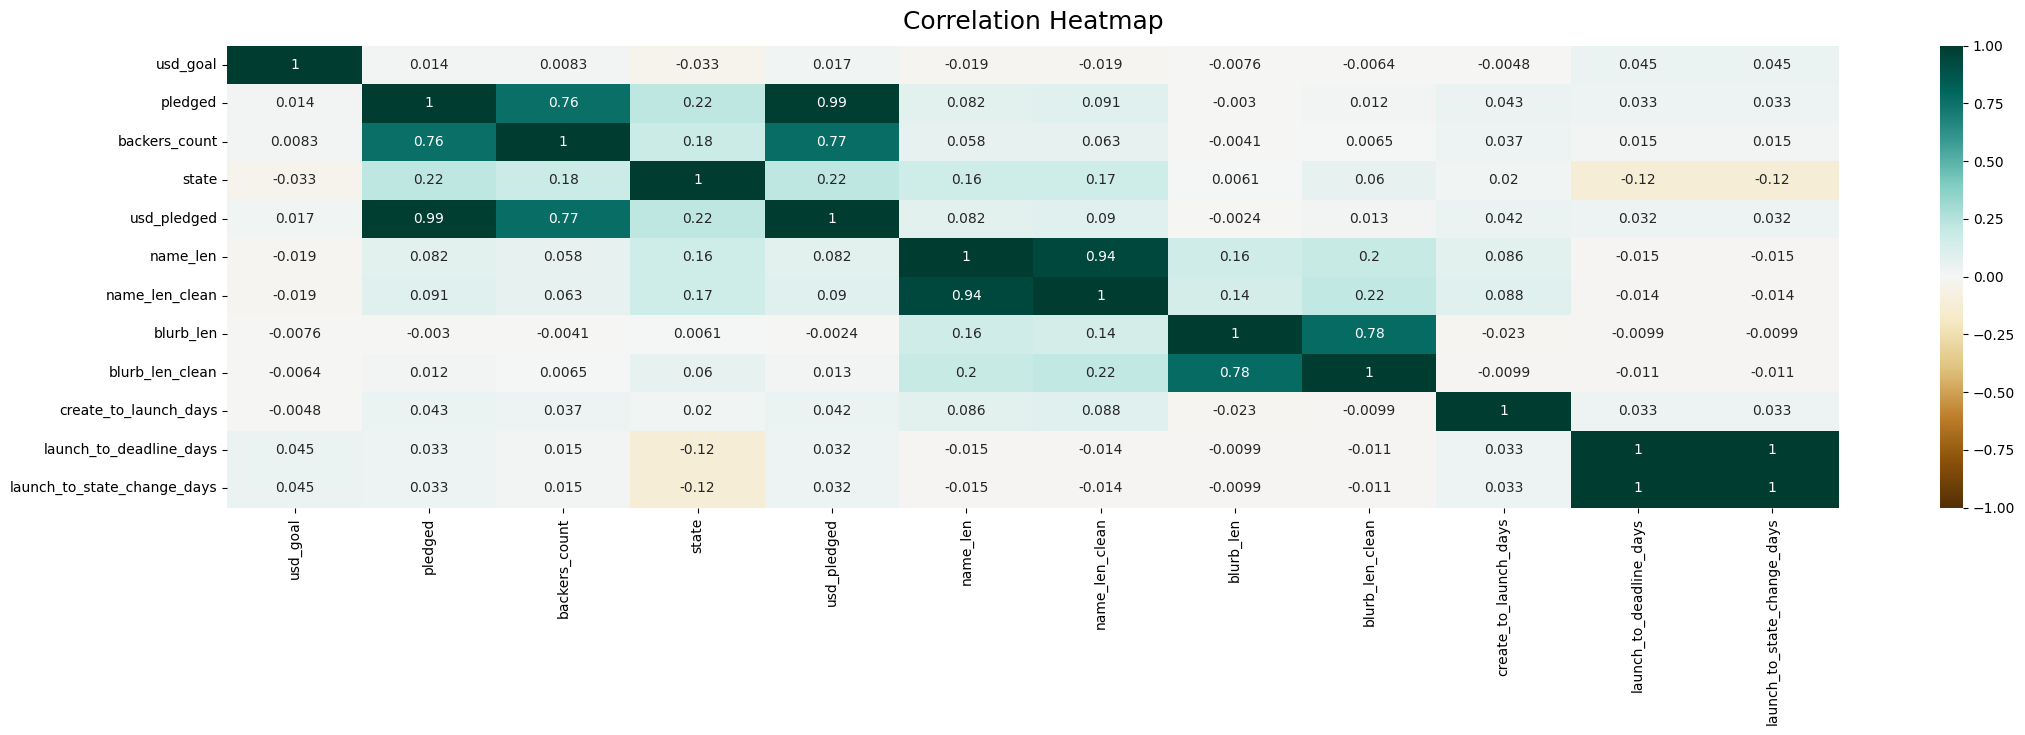

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap_clustering.png', dpi=300, bbox_inches='tight')

According to the correlation heatmap, following varaibles have high correlation (>0.75):
- usd_pledged and pledged,
- pledged and backers_count,
- name_len and name_len_clean, 
- blurb_len and blurb_len_clean,
- launch_to_deadline_days and launch_to_state_change_days

For each pair, we only need to keep one of them.

In [50]:
df = df.drop(columns = ['usd_pledged','name_len_clean','launch_to_state_change_days', 'backers_count', 'blurb_len_clean'])
df.columns

Index(['usd_goal', 'pledged', 'state', 'name_len', 'blurb_len',
       'create_to_launch_days', 'launch_to_deadline_days'],
      dtype='object')

In [51]:
df.describe()

,usd_goal,pledged,state,name_len,blurb_len,create_to_launch_days,launch_to_deadline_days
count,1.343500e+04,1.343500e+04,13435.000000,13435.000000,13435.000000,13435.000000,13435.000000
mean,9.107229e+04,2.189293e+04,0.340528,5.804466,19.061035,46.746185,34.445032
std,1.520810e+06,1.205956e+05,0.473905,2.835594,4.545389,101.006404,11.936018
min,1.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,0.000000,1.000000
25%,3.500000e+03,3.000000e+01,0.000000,3.000000,17.000000,4.000000,30.000000
50%,1.109928e+04,8.010000e+02,0.000000,6.000000,20.000000,14.000000,30.000000
75%,3.999950e+04,6.501505e+03,1.000000,8.000000,22.000000,43.000000,39.000000
max,1.000000e+08,6.225355e+06,1.000000,16.000000,35.000000,1528.000000,91.000000


In [57]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100,contamination=.1)

pred = iforest.fit_predict(df)
score = iforest.decision_function(df)

# Extracting anomalies
from numpy import where
anomaly_index = where(pred==-1)
anomaly_values = df.iloc[anomaly_index]

for idx in anomaly_index:
    df = df.drop(idx, errors='ignore')

df.shape

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(11032, 7)

# 2. Define Clusters Measurement

In [58]:
from sklearn.metrics import silhouette_samples

newdf = df
def cal_silhouette(X, labels):
    silhouette = silhouette_samples(X, labels)
         # silhouette score for each indiviual data points, > 0.5 is strong
    newdf['labels'] = labels
    newdf['silhouette'] = silhouette

    K = len(np.unique(labels))
    print('Average Silhouette Score for each cluster:')
    for i in range(K):
        print(i,'=',np.average(newdf[newdf['labels'] == i].silhouette))


# 3. Clustering Analysis

In [74]:
X = df #[['usd_goal', 'pledged', 'name_len', 'blurb_len',
       #'create_to_launch_days', 'launch_to_deadline_days']] 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# X_std = X

## 3.1 K-Means Clustering

### 3.1.1 Find the optimal K

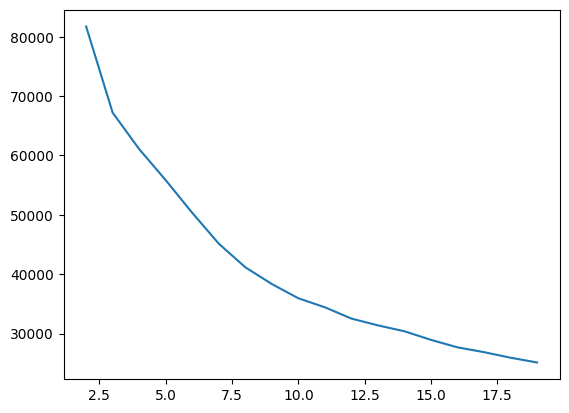

In [75]:
# Calculate inertia for each number of clusters in kmeans
from sklearn.cluster import KMeans

withinss = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(X_std)
    withinss.append(model.inertia_)

from matplotlib import pyplot
pyplot.plot([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],withinss)

In [76]:
from sklearn.metrics import silhouette_score
for i in range (2,11):    
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(X_std)
    labels = model.labels_
    print(i,':',silhouette_score(X_std,labels))

2 : 0.2092204213773838
3 : 0.24150981849427466
4 : 0.24793888846818538
5 : 0.2225081969865848
6 : 0.23741462966128207
7 : 0.2502544832536067
8 : 0.2729986058667349
9 : 0.26450087791079635
10 : 0.27001685514049156


### 3.1.2 Run the model with optimal K

In [86]:
K = 7

In [87]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K)
model_km = kmeans.fit(X_std)
labels_km = model_km.predict(X_std)

for i in range(K):
    print(i, (labels_km == i).sum())

0 2755
1 3923
2 388
3 530
4 40
5 1358
6 2038


In [88]:
cal_silhouette(X_std,labels_km)

Average Silhouette Score for each cluster:
0 = 0.32573348316851164
1 = 0.2015067395981779
2 = 0.2736371864662085
3 = 0.21187955399255015
4 = 0.3687665714376794
5 = 0.16147836449223252
6 = 0.30470042447249884


In [ ]:
X.columns

In [ ]:
cluster_df = pd.DataFrame(scaler.inverse_transform(model_km.cluster_centers_), columns = X.columns)
cluster_df.loc['Mean'] = X.mean().to_numpy() #np.mean(X_std, axis=0)

cluster_df

## 3.2. Agglomerative Approach

In [82]:
from sklearn.cluster import AgglomerativeClustering

def quick_agg(linkage): 
    model = AgglomerativeClustering(n_clusters=K,affinity='euclidean',linkage=linkage)
    model.fit_predict(X_std)
    labels = model.labels_

    print('\nLinkage = ', linkage)
    for i in range(K):
        print(i, (model.labels_ == i).sum())
    
    return labels

In [89]:
labels_complete = quick_agg('complete')
labels_single = quick_agg('single')
labels_average = quick_agg('average')


Linkage =  complete
0 10659
1 70
2 255
3 8
4 2
5 30
6 8

Linkage =  single
0 11025
1 2
2 1
3 1
4 1
5 1
6 1

Linkage =  average
0 33
1 2
2 58
3 8
4 10856
5 1
6 74


In [90]:
cal_silhouette(X_std, labels_complete)
cal_silhouette(X_std, labels_single)
cal_silhouette(X_std, labels_average)

Average Silhouette Score for each cluster:
0 = 0.4323497601068179
1 = 0.550240921415651
2 = 0.38078582588770643
3 = 0.5646166899705743
4 = 0.4958578172032496
5 = 0.5960765387431455
6 = 0.6622382192189734
Average Silhouette Score for each cluster:
0 = 0.5490852123612573
1 = 0.6385354432107626
2 = 0.0
3 = 0.0
4 = 0.0
5 = 0.0
6 = 0.0
Average Silhouette Score for each cluster:
0 = 0.5389054980305635
1 = 0.4958578172032496
2 = 0.5498721586326948
3 = 0.572823982490548
4 = 0.5583210460523964
5 = 0.0
6 = 0.5219192082008913
